# MVO for multiple Asset Classes

## Few helper functions

In [3]:
import scipy.optimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculates portfolio mean return
def port_mean(W, R):
    return sum(R * W)

# Calculates portfolio variance of returns
def port_var(W, C):
    return np.dot(np.dot(W, C), W)

# Combination of the two functions above - mean and variance of returns calculation
def port_mean_var(W, R, C):
    return port_mean(W, R), port_var(W, C)

# Given risk-free rate, assets returns and covariances, this function calculates
# mean-variance frontier and returns its [x,y] points in two arrays
def solve_frontier(R, C, rf):
    def fitness(W, R, C, r):
        # For given level of return r, find weights which minimizes portfolio variance.
        mean, var = port_mean_var(W, R, C)
        penalty = 100 * abs(
            mean - r)  # Big penalty for not meeting stated portfolio return effectively serves as optimization constraint
        return var + penalty

    frontier_mean, frontier_var, frontier_weights = [], [], []
    n = len(R)  # Number of assets in the portfolio
    for r in np.linspace(min(R), max(R), num=20):  # Iterate through the range of returns on Y axis
        W = np.ones([n]) / n  # start optimization with equal weights
        b_ = [(0, 1) for i in range(n)]
        c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)
        if not optimized.success:
            raise BaseException(optimized.message)
        # add point to the efficient frontier [x,y] = [optimized.x, r]
        frontier_mean.append(r)
        frontier_var.append(port_var(optimized.x, C))
        frontier_weights.append(optimized.x)
    return np.array(frontier_mean), np.array(frontier_var), frontier_weights

# Given risk-free rate, assets returns and covariances, this function calculates
# weights of tangency portfolio with respect to sharpe ratio maximization
def solve_weights(R, C, rf):
    def fitness(W, R, C, rf):
        mean, var = port_mean_var(W, R, C)  # calculate mean/variance of the portfolio
        util = (mean - rf) / np.sqrt(var)  # utility = Sharpe ratio
        return 1 / util  # maximize the utility, minimize its inverse value
    n = len(R)
    W = np.ones([n]) / n  # start optimization with equal weights
    b_ = [(0., 1.) for i in range(n)]  # weights for boundaries between 0%..100%. No leverage, no shorting
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})  # Sum of weights must be 100%
    optimized = scipy.optimize.minimize(fitness, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
    if not optimized.success: raise BaseException(optimized.message)
    return optimized.x

class Result:
    def __init__(self, W, tan_mean, tan_var, front_mean, front_var, front_weights):
        self.W=W
        self.tan_mean=tan_mean
        self.tan_var=tan_var
        self.front_mean=front_mean
        self.front_var=front_var
        self.front_weights=front_weights
        
def optimize_frontier(R, C, rf):
    W = solve_weights(R, C, rf)
    tan_mean, tan_var = port_mean_var(W, R, C)  # calculate tangency portfolio
    front_mean, front_var, front_weights = solve_frontier(R, C, rf)  # calculate efficient frontier
    # Weights, Tangency portfolio asset means and variances, Efficient frontier means and variances
    return Result(W, tan_mean, tan_var, front_mean, front_var, front_weights)

def display_assets(names, R, C, color='black'):
    n = len(names)
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), plt.grid(True)  # draw assets
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color) # draw labels

# def display_frontier(result: Result, label=None, color='black'):
#     from collections import defaultdict
#     from IPython.core.display import HTML
#     # plt.text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment='bottom', color='r')
#     plt.scatter(result.tan_var ** .5, result.tan_mean, marker='o', color=color), plt.grid(True)
#     plt.plot(list(result.front_var ** .5), list(result.front_mean), label=label, color=color), plt.grid(True)  # draw efficient frontier
    
#     table = defaultdict(list)
#     for mean, var, weights in zip(result.front_mean, result.front_var, result.front_weights):
#         table['Mean'].append(mean)
#         table['Variance'].append(var)
#         for name, weight in zip(names, weights):
#             table[name].append(weight)
#     display(HTML(f'<b>Efficient frontier portfolios ({label})</b>'), pd.DataFrame(table))

## Load Historical Prices

In [5]:
def load_data():
    """
    Load data from a CSV file and return a list of symbols and their corresponding prices.

    Returns:
    symbols (list): A list of symbols.
    prices_out (list): A list of lists containing the prices for each symbol.
    """
    symbols = ['IMA-S', 'IMA-B', 'IRF-M', 'IHFA', 'Ibovespa', 'S&P 500']
    n = len(symbols)
    prices_out = []
    for s in symbols:
        dataframe = pd.read_csv('G:/My Drive/Poli-USP/TCC/Codes/MVO/AA_indexes.csv', 
                                index_col=['Data'],
                                sep=';', decimal=',', thousands=" ",
                                parse_dates=['Data'])
        prices = list(dataframe.loc['2014-01-01':'2023-12-31', s])
        prices_out.append(prices)
    return symbols, prices_out

names, prices = load_data()

# display(prices)


## Estimate assets hitorical return and covariances

In [6]:
# Function takes historical stock prices together with market capitalizations and
# calculates weights, historical returns and historical covariances
def assets_historical_returns_and_covariances(prices):
    prices = np.matrix(prices)  # create numpy matrix from prices
    # create matrix of historical returns
    rows, cols = prices.shape # each row is an asset
    returns = np.empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1 # create a matrix of returns
    # calculate returns
    expreturns = np.array([]) 
    expreturns = np.append(expreturns, (prices[:, -1] / prices[:, 0]))**(1/10) - 1 # Annualize returns
    # expreturns = np.append(expreturns, np.mean(returns, axis=1)) # daily expected return for each asset
    # expreturns = (1 + expreturns) ** (cols/10) - 1  # Annualize returns
    # calculate covariances
    covars = np.cov(returns)
    covars = covars * cols/10  # Annualize covariances
    return expreturns, covars

R, C = assets_historical_returns_and_covariances(prices)
rf = 0.0928  # Risk-free rate

# where x is an array with a list or a matrix
def percentage(x):
    if len(x.shape) == 2:
        x = np.round(np.multiply(x, 100), 2)
        perc_x = np.empty(x.shape, dtype=object)
        for r in range(x.shape[0]):
            for c in range(x.shape[1]):
                perc_x[r, c] = str(x[r, c]) + '%'
    else:
        perc_x = np.round(np.multiply(x, 100), 2)
        perc_x = [str(value) + '%' for value in perc_x]
    return perc_x

vol = np.sqrt(np.diagonal(C))
display(pd.DataFrame({'Return': percentage(R)}, index=names).T)
display(pd.DataFrame({'Volatility': percentage(vol)}, index=names).T)
display(pd.DataFrame(percentage(C), index=names, columns=names))

## Mean-Variance Optimization

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\pedro\AppData\Local\Temp\ipykernel_18528\884786114.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.show()
C:\Users\pedro\AppData\Local\Temp\ipykernel_18528\884786114.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.show()


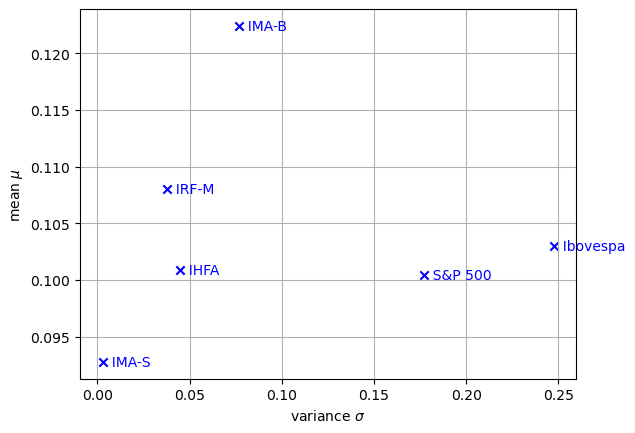

,IMA-S,IMA-B,IRF-M,IHFA,Ibovespa,S&P 500
Weight,0.0,0.18507,0.81493,2.034935e-16,7.987969e-16,0.0


In [8]:
res1 = optimize_frontier(R, C, rf)

display_assets(names, R, C, color='blue')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.show()
display(pd.DataFrame({'Weight': res1.W}, index=names).T)